# A Deep Learning Exercise in "Transfer Learning"

#### Example by:  **Nick Kelley**, Feb 2017
for our Deep Learning Hackathon, organized by:
#### **Nick Kelley, Tobias Sing, Imtiaz Hossain, William Jose Godinez Navarro, Giovanni d'Ario, Chris Ball, Wolfgang Zipfel**

### Here we give an example of how to use features a CNN has already learned from other images in order to better learn about your own images:


In the previous examples, the network has learned all of it's weights from the set of training data.

For more complex real-world images, these featuers can be much more complicated and more numerous than those necessary to represent handwritten digits.  

However, many common motifs from the world around us will be found in many different images - think circles and rectangles for example.  If we're lukcy, many of those features relevant to you will have been present in the ['big data'](http://www.image-net.org) which a giant network - such as Google's [inceptionV3](https://arxiv.org/abs/1512.00567) - was trained on, and hence potentially already learned.  

The concept behind transfer learning is simple:  reuse the types of features learned by other extensively trained networks for other different but related problems.  

In [1]:
Image('/da/dmp/hackathon/notebooks/images/retrain.jpg')

NameError: name 'Image' is not defined


### Auto-encoder analogy:
It might also help you to consider the case of the unsupervised [auto-encoder](https://deeplearning4j.org/deepautoencoder), which William will talk about later if we have time.  In this case the information is collapsed to a bottle neck state, which is a compressed representation of the data, and then uncompressed in a way to ensure minimal loss.  What we've learned are the common patterns or features in the data.  Consider a biological pathway instead of individual genes.  Learning can also be thought of as data compression.  This new representaiton can then be used to more easily answer questions and interpret the data.  

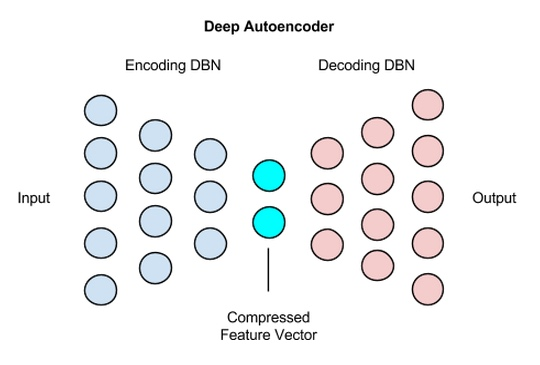

In [103]:
Image('/da/dmp/hackathon/notebooks/images/deep_autoencoder.jpg')

## The practical take
For many tasks, we might not have the compute power or (even more likely) the data to properly train a model with enough complexity to handle our problem.  Whether it is imaging, cheminformatics - the Brokerbridge consortium is a great example of collaborating to learn features - or other types of data, this could be a powerful way to quickly address many of the logistic challenges associated with deep learning.  

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

import six as _six

import matplotlib.pyplot as plt

import os
import glob
import re
import hashlib
from keras.preprocessing.image import ImageDataGenerator

#from IPython.display import Image
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)
Traceback (most recent call last):
  File "/usr/prog/python/2.7.11-goolf-1.5.14-NX/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 5] Input/output error
Logged from file __init__.py, line 518
Traceback (most recent call last):
  File "/usr/prog/python/2.7.11-goolf-1.5.14-NX/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 5] Input/output error
Logged from file ioloop.py, line 629


In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
K.set_image_dim_ordering('th')

In [4]:
%matplotlib inline

In [5]:
#Leave as mine for the example if not using your own data
your_521='kelleni2'

In [142]:
'''%%bash
mkdir /da/dmp/hackathon/flower_processed/YOUR-521''''''

In [6]:
image_dir='/da/dmp/hackathon/flower_photos/'
flower_521_dir='/da/dmp/hackathon/flower_processed/%s'%your_521
premade_flower_521='/da/dmp/hackathon/flower_processed/kelleni2'
testing_dir='/da/dmp/hackathon/abstract_flowers/'
testing_percentage=19
validation_percentage=1
MAX_NUM_IMAGES_PER_CLASS=1000
#FOR FLOWER DATA SET:
class_count=5

#### To run on your own images, here is some code to split them into training and testing folders, but for today you may want to simply use my data already split into folders, in the name of time.   

In [8]:
def as_bytes(bytes_or_text, encoding='utf-8'):
  if isinstance(bytes_or_text, _six.text_type):
    return bytes_or_text.encode(encoding)
  elif isinstance(bytes_or_text, bytes):
    return bytes_or_text
  else:
    raise TypeError('Expected binary or unicode string, got %r' %
                    (bytes_or_text,))

def create_image_lists(image_dir, testing_percentage, validation_percentage):
  if not os.path.exists(image_dir):
    print("Image directory '" + image_dir + "' not found.")
    return None
  result = {}
  sub_dirs = [x[0] for x in os.walk(image_dir)]
  is_root_dir = True
  for sub_dir in sub_dirs:
    if is_root_dir:
      is_root_dir = False
      continue
    extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    print("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(glob.glob(file_glob))
    if not file_list:
      print('No files found')
      continue
    if len(file_list) < 20:
      print('WARNING: Folder has less than 20 images, which may cause issues.')
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      print('WARNING: Folder {} has more than {} images. Some images will '
            'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      hash_name_hashed = hashlib.sha1(as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        training_images.append(base_name)
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result

In [9]:
# THE FUNCTIONS FOR THIS CELL ARE AT THE END OF THE  
# Look at the folder structure, and create lists of all the images.
image_lists = create_image_lists(image_dir, testing_percentage,
                                   validation_percentage)
class_count = len(image_lists.keys())
if class_count == 0:
    print('No valid folders of images found at ' + image_dir)
#return -1
if class_count == 1:
    print('Only one valid folder of images found at ' + image_dir +
      ' - multiple classes are needed for classification.')
        #return -1

Looking for images in 'sunflowers'
Looking for images in 'daisy'
Looking for images in 'tulips'
Looking for images in 'roses'
Looking for images in 'dandelion'


In [10]:
image_lists.keys()

['tulips', 'roses', 'dandelion', 'sunflowers', 'daisy']

In [11]:
image_lists['roses'].keys()

['training', 'testing', 'dir', 'validation']

In [12]:
[(x,len(image_lists['roses'][x])) for x in image_lists['roses'].keys()]

[('training', 519), ('testing', 113), ('dir', 5), ('validation', 9)]

In [105]:
#Here is the loop for copying files into new testing and training directories if you like
'''os.mkdir('/da/dmp/hackathon/flower_processed/%s'%your_521)'''
'''for ttype in ('training','testing'):

    #os.mkdir(os.path.join(flower_521_dir,ttype))
    for label in image_lists.keys():
        target=os.path.join(flower_521_dir,ttype,label)
        print(target)
        #os.mkdir(target)
        for fname in image_lists[label][ttype]:
            source=os.path.join(image_dir,label,fname)
            #os.system('cp %s %s'%(source,target))'''


"for ttype in ('training','testing'):\n\n    #os.mkdir(os.path.join(flower_521_dir,ttype))\n    for label in image_lists.keys():\n        target=os.path.join(flower_521_dir,ttype,label)\n        print(target)\n        #os.mkdir(target)\n        for fname in image_lists[label][ttype]:\n            source=os.path.join(image_dir,label,fname)\n            #os.system('cp %s %s'%(source,target))"

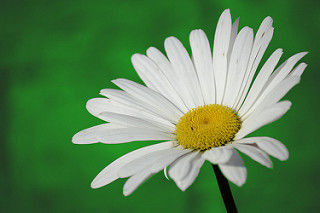

In [40]:
from IPython.display import Image
label=image_lists.keys()[-1]
fname=image_lists[label]['testing'][-1]
source=os.path.join(image_dir,label,fname)
#os.chdir(testing_dir)
Image(source)

# Making Tensors "flow"...
# Preparing our data to be fed into our model

### This first block of code defines a generator creating object which can read in images from a directory
### We also give it rules on if it should distort or transform the data.
#### Note that we don't want to distort the test data

In [13]:
# Do you want to distort and rescale images to create more training examples? 
distort=0

if not distort:
    train_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()
else:
    '''THIS ONE WOULD BE IF YOU WANT TO DISTORT'''
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

### Now create your generator by defining your directory, batch size, and target size for your image

In [14]:
train_generator = train_datagen.flow_from_directory(
        os.path.join(flower_521_dir,'training'),  # this is the target directory
        target_size=(250, 250),  # all images will be resized to 150x150
        batch_size=32)
#        class_mode='binary') 
test_generator = train_datagen.flow_from_directory(
        os.path.join(flower_521_dir,'testing'),  # this is the target directory
        target_size=(250, 250),  # all images will be resized to 150x150
        batch_size=32)

Found 2909 images belonging to 5 classes.
Found 728 images belonging to 5 classes.


# First, let's give it a try with our previous MNIST CNN architecture

In [16]:
#But change input shape from (1,28,28) to (3,500,500) because we have larger color images - 3 channels
def model1(num_classes):
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(3, 250,250), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model   

In [107]:
MNISTmodel=model1(class_count)

In [19]:
# train the model on the new data for a few epochs
hist= MNISTmodel.fit_generator(
        train_generator,
        samples_per_epoch=800,
        nb_epoch=5,
        validation_data=test_generator,
        nb_val_samples=64)
MNISTmodel.save_weights('MNIST_model_Oxford102.h5')  # always save your weights after training or during training

Epoch 1/5
800/800 [==============================] - 32s - loss: 12.3706 - acc: 0.2325 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 2/5
800/800 [==============================] - 28s - loss: 12.0080 - acc: 0.2550 - val_loss: 13.3478 - val_acc: 0.1719
Epoch 3/5
797/800 [============================>.] - ETA: 0s - loss: 11.9116 - acc: 0.2610

/usr/prog/pythonML/3.2-goolf-1.5.14-NX-python-2.7.11/lib/python2.7/site-packages/Keras-1.1.2-py2.7.egg/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


829/800 [===============================] - 27s - loss: 11.8990 - acc: 0.2618 - val_loss: 12.5923 - val_acc: 0.2188
Epoch 4/5
800/800 [==============================] - 29s - loss: 11.9072 - acc: 0.2613 - val_loss: 12.3404 - val_acc: 0.2344
Epoch 5/5
800/800 [==============================] - 24s - loss: 12.4512 - acc: 0.2275 - val_loss: 12.3404 - val_acc: 0.2344


NameError: name 'model' is not defined

In [74]:
# train the model on the new data for a few epochs
hist= MNISTmodel.fit_generator(
        train_generator,
        samples_per_epoch=800,
        nb_epoch=10,
        validation_data=test_generator,
        nb_val_samples=64)
MNISTmodel.save_weights('MNIST_model_Oxford102.h5')  # always save your weights after training or during training

Epoch 1/20
800/800 [==============================] - 27s - loss: 13.3176 - acc: 0.1738 - val_loss: 13.3478 - val_acc: 0.1719
Epoch 2/20
800/800 [==============================] - 23s - loss: 13.1161 - acc: 0.1862 - val_loss: 12.3404 - val_acc: 0.2344
Epoch 3/20
800/800 [==============================] - 24s - loss: 13.7205 - acc: 0.1487 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/20
829/800 [===============================] - 26s - loss: 13.5322 - acc: 0.1604 - val_loss: 11.3330 - val_acc: 0.2969
Epoch 5/20
800/800 [==============================] - 24s - loss: 13.4183 - acc: 0.1675 - val_loss: 13.5996 - val_acc: 0.1562
Epoch 6/20
800/800 [==============================] - 24s - loss: 13.5996 - acc: 0.1562 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 7/20
800/800 [==============================] - 25s - loss: 13.4183 - acc: 0.1675 - val_loss: 13.3478 - val_acc: 0.1719
Epoch 8/20
829/800 [===============================] - 27s - loss: 13.3767 - acc: 0.1701 - val_loss: 12.6381 - val_ac

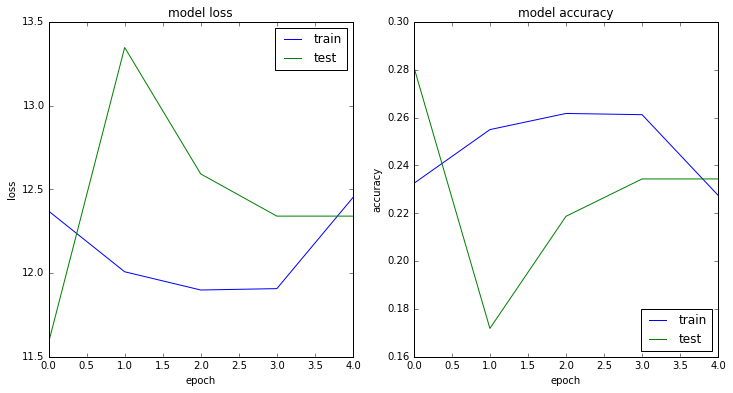

In [20]:
# Plot the loss
history=hist
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# ...and the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# How did your model perform?
# Let's try to classify our flowers by retraining just the top layer of Google's inception V3 pre-trained neural network.

In [21]:
# create the base pre-trained model, leave out top layers
base_model = InceptionV3(weights='imagenet', include_top=False)

### FYI save or load the weights of a model:

In [22]:
base_model.save_weights('/da/dmp/hackathon/inception_base.h5')

In [25]:
base_model.load_weights('/da/dmp/hackathon/inception_base.h5')

#### Note that to speed up training, you can save the bottleneck states of the InceptionV3 base model, so they need not be recomputed each epoch.  

We're not going to do this because it's more compliated with the i/o, but see below for an example of how to get the bottleneck vector for the first image:

In [23]:
base_model.predict_generator(test_generator,32)  #Remember: test_generator is the incoming list of images, in batches of 32
# Save the output as a Numpy array:
#base_model.predict_generator(un_shuffled_generator,len(whatever))
#np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

array([[[[  -0.43353286,   -0.43353286,   -0.43353286, ...,   -0.43353286,
            -0.43353286,   -0.43353286],
         [  -0.43353286,   -0.43353286,   -0.43353286, ...,   -0.43353286,
            -0.43353286,   -0.43353286],
         [  -0.43353286,   -0.43353286,   -0.43353286, ...,   -0.43353286,
            -0.43353286,   -0.43353286],
         ..., 
         [  -0.43353286,   -0.43353286,   -0.43353286, ...,   -0.43353286,
            -0.43353286,   -0.43353286],
         [  -0.43353286,   -0.43353286,   -0.43353286, ...,   -0.43353286,
            -0.43353286,   -0.43353286],
         [  -0.43353286,   -0.43353286,   -0.43353286, ...,   -0.43353286,
            -0.43353286,   -0.43353286]],

        [[  -0.378227  ,   -0.378227  ,   -0.378227  , ...,   -0.378227  ,
            -0.378227  ,   -0.378227  ],
         [  -0.378227  ,   -0.378227  ,   -0.378227  , ...,   -0.378227  ,
            -0.378227  ,   -0.378227  ],
         [  -0.378227  ,   -0.378227  ,   -0.378227  , 

# OK!  Now time to add connections to the output layers!

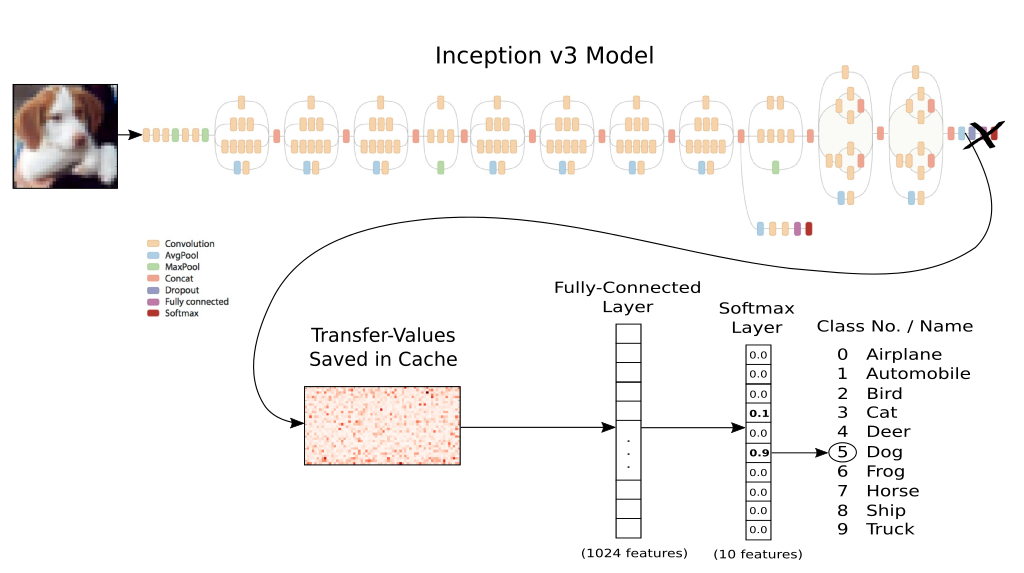

In [77]:
from IPython.display import Image
Image('/da/dmp/hackathon/notebooks/images/08_transfer_learning_flowchart.png')

In [27]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(250, activation='relu')(x)
# and a logistic layer -- let's say we have N classes
predictions = Dense(class_count, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

### Now train on the data!

In [28]:
hist= model.fit_generator(
        train_generator,
        samples_per_epoch=800,
        nb_epoch=5,
        validation_data=test_generator,
        nb_val_samples=64)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/5
800/800 [==============================] - 30s - loss: 0.7234 - acc: 0.7263 - val_loss: 1.1938 - val_acc: 0.6562
Epoch 2/5
829/800 [===============================] - 29s - loss: 0.4676 - acc: 0.8347 - val_loss: 0.5062 - val_acc: 0.8125
Epoch 3/5
800/800 [==============================] - 32s - loss: 0.4363 - acc: 0.8550 - val_loss: 1.0695 - val_acc: 0.7031
Epoch 4/5
800/800 [==============================] - 27s - loss: 0.4274 - acc: 0.8550 - val_loss: 0.4391 - val_acc: 0.9219
Epoch 5/5
829/800 [===============================] - 29s - loss: 0.3815 - acc: 0.8613 - val_loss: 0.3401 - val_acc: 0.8750


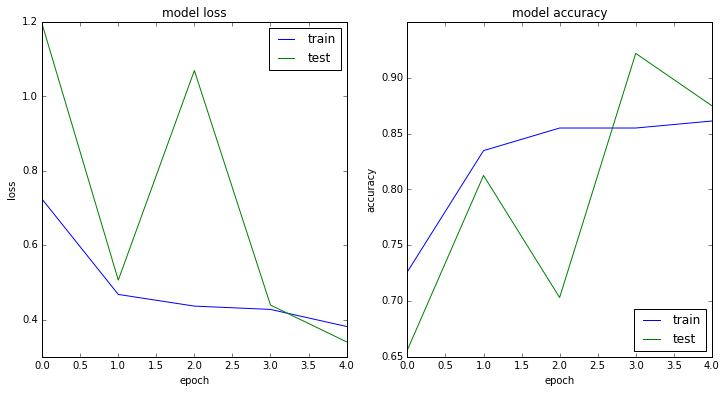

In [30]:
# Plot the loss
history=hist
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# ...and the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Now we'll see how our model works on abstract or confusing pictures
# "Flower Paintings" rather than "Flower

In [32]:
'''This function is just to easily see the top predictions made in words'''
def print_prediction(x,train_generator,cutoff=0.05):
    D={v: k for k, v in train_generator.class_indices.iteritems()}
    for xx in x:
        for i in range(len(xx)):
            if xx[i]>=cutoff:
                print(D[i],'\t','%2.2f'%xx[i],)
    print('\n')
            
    

In [33]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

(0, '\t', 'abstract-tulips-flowers-oil-painting-colour-41887848.jpg')
('roses', '\t', '0.73')
('tulips', '\t', '0.26')


(1, '\t', 'abstract-flower-dandelion-vector-1848920.jpg')
('dandelion', '\t', '1.00')


(2, '\t', 'dandelion-canvas.jpg')
('dandelion', '\t', '0.91')
('sunflowers', '\t', '0.08')


(3, '\t', 'the-abstract-rose-test.png')
('tulips', '\t', '1.00')


(4, '\t', 'abstract-line-sunflower-yellow-green-background-34571432.jpg')
('dandelion', '\t', '0.16')
('sunflowers', '\t', '0.75')
('tulips', '\t', '0.06')


(5, '\t', 'abstract_rose_3_by_lady_erin.jpg')
('roses', '\t', '0.96')


(6, '\t', 'dandelion-color.jpg')
('daisy', '\t', '0.79')
('roses', '\t', '0.07')
('sunflowers', '\t', '0.07')
('tulips', '\t', '0.07')


(7, '\t', 'unknown-flowers-butterfly.jpg')
('tulips', '\t', '0.96')


(8, '\t', 'tree-with-flowers-vector-298509.jpg')
('roses', '\t', '0.75')
('tulips', '\t', '0.23')


(9, '\t', 'purple-tulip-watercolor.jpg')
('roses', '\t', '0.16')
('tulips', '\t', '0.84')


(1

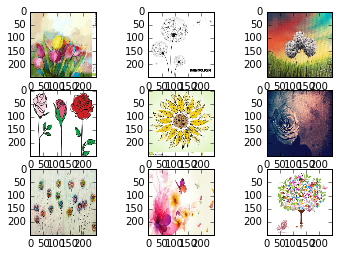

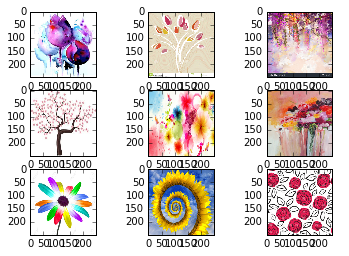

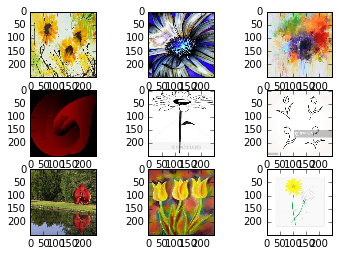

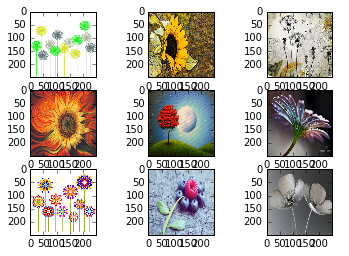

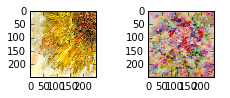

In [41]:
prediction_dir='/da/dmp/hackathon/abstract_flowers'
count=-1
myPicList=os.listdir(prediction_dir)
for filename in myPicList:

    count+=1
    print(count,'\t',filename)
    
    img = load_img(os.path.join(prediction_dir,filename))  # this is a PIL image
    img = img.resize((250,250)) 

    if count%9==0:
        plt.figure()
    plt.subplot(3,3,(count%9)+1)
    plt.imshow(img)

    x = img_to_array(img)  # this is a Numpy array with shape (3, 250, 250)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 250, 250)
    classes = model.predict(x,batch_size=1)

    print_prediction(classes,train_generator)

### Below you can look at the image by number - choose one where the prediction was wrong.  
### In my training it thought 21 was a sunflower for example, I would assume becuaes of it's round shape!

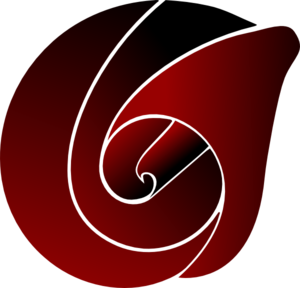

In [42]:
myImageNumber=21
from IPython.display import Image
os.chdir(testing_dir)
myImageFile=os.path.join(prediction_dir,myPicList[myImageNumber])
Image(myImageFile)

# Now lets look at features for that image!

In [76]:
from keras import backend as K

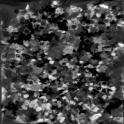

In [104]:
import random, scipy
myImageNumber=len(myPicList)-1
myImageFile=os.path.join(prediction_dir,myPicList[myImageNumber])
get_layer_output = K.function([base_model.layers[0].input],
                                  [base_model.layers[1].output])
'''for i in range(len( number_of_features  )):'''
    #t=copy.deepcopy(X_train[i:i+1])
    #t=t.astype(np.float32,copy=False)
    #newt=model.layers[0].call(t)
    
img = load_img(myImageFile)  # this is a PIL image
img = img.resize((250,250)) 


x = img_to_array(img)  # this is a Numpy array with shape (3, 250, 250)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 250, 250)

fnumber=0#random.randint(1,20)
layer_output = get_layer_output([x])[0]
mylayer=layer_output[0,fnumber,:,:]

scipy.misc.imsave('image%i_layer1_f-%i.jpg'%(myImageNumber,fnumber), mylayer)
Image('image%i_layer1_f-%i.jpg'%(myImageNumber,fnumber))

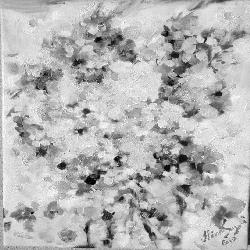

In [105]:
import random, scipy
myImageNumber=len(myPicList)-1
myImageFile=os.path.join(prediction_dir,myPicList[myImageNumber])

get_layer_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[0].output])
'''for i in range(len( number_of_features  )):'''
    #t=copy.deepcopy(X_train[i:i+1])
    #t=t.astype(np.float32,copy=False)
    #newt=model.layers[0].call(t)
    
img = load_img(myImageFile)  # this is a PIL image
img = img.resize((250,250)) 


x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

fnumber=0#random.randint(1,20)
layer_output = get_layer_output([x,0])[0]
mylayer=layer_output[0,fnumber,:,:]

scipy.misc.imsave('image%i_Lphase_layer1_f-%i.jpg'%(myImageNumber,fnumber), mylayer)
Image('image%i_Lphase_layer1_f-%i.jpg'%(myImageNumber,fnumber))

In [90]:
layer_output.shape

(1, 32, 124, 124)

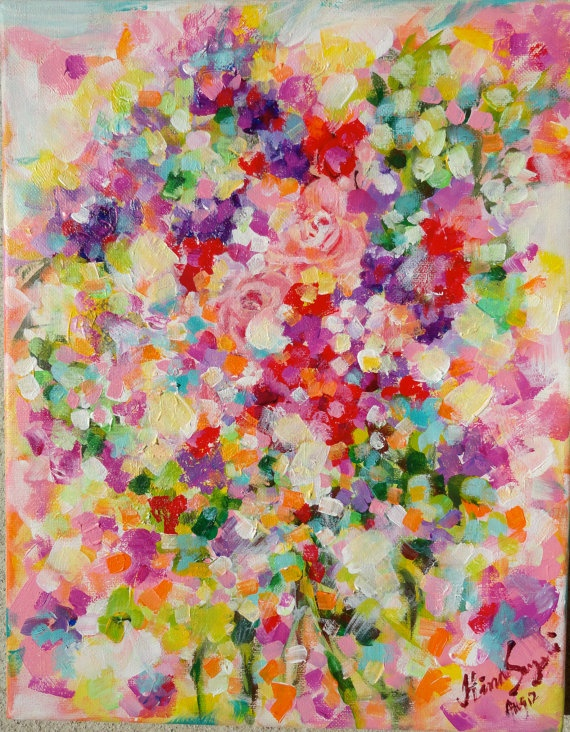

In [106]:
Image(myImageFile)

## Some code for retraining some of the inceptionv3 base layers if wanted

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[b172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)